In [165]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [166]:
import numpy as np
import pandas as pd
from datetime import datetime

In [167]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [169]:
import os
%reload_ext tensorboard

In [261]:
def build_model():
    model=tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(4,input_shape=(4,)))
    #model.add(tf.keras.layers.Dense(25,activation='relu'))
    #model.add(tf.keras.layers.Dense(15,activation='relu'))
    #model.add(tf.keras.layers.Dense(5,activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])                         
    return model

model=build_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [171]:
X=np.arange(0,2000).reshape(-1,4)
y=np.arange(5,(X.shape[0]+1)*5,5)

temp=pd.DataFrame(data=X)
temp['target']=pd.Series(y.reshape(-1,))
temp.head()

,0,1,2,3,target
0,0,1,2,3,5
1,4,5,6,7,10
2,8,9,10,11,15
3,12,13,14,15,20
4,16,17,18,19,25


In [172]:
from sklearn.preprocessing import StandardScaler
inputs_standardizer=StandardScaler()
inputs_standardizer.fit_transform(temp.drop('target',axis=1).values.tolist())

target_standardizer=StandardScaler()
target_standardizer.fit_transform(temp['target'].values.reshape(-1,1).tolist())

norm_temp=pd.DataFrame(data=inputs_standardizer.fit_transform(temp.drop('target',axis=1).values.tolist()))
norm_temp['target']=pd.Series(target_standardizer.fit_transform(temp['target'].values.reshape(-1,1).tolist()).reshape(-1,))
norm_temp.head()

,0,1,2,3,target
0,-1.728590,-1.728590,-1.728590,-1.728590,-1.728590
1,-1.721662,-1.721662,-1.721662,-1.721662,-1.721662
2,-1.714734,-1.714734,-1.714734,-1.714734,-1.714734
3,-1.707806,-1.707806,-1.707806,-1.707806,-1.707806
4,-1.700877,-1.700877,-1.700877,-1.700877,-1.700877


In [173]:
train_dataset = temp.sample(frac=0.8,random_state=0)
test_dataset = temp.drop(train_dataset.index)


In [174]:
train_stats = temp.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
0,500.0,998.0,577.927331,0.0,499.00,998.0,1497.00,1996.0
1,500.0,999.0,577.927331,1.0,500.00,999.0,1498.00,1997.0
2,500.0,1000.0,577.927331,2.0,501.00,1000.0,1499.00,1998.0
3,500.0,1001.0,577.927331,3.0,502.00,1001.0,1500.00,1999.0
target,500.0,1252.5,722.409164,5.0,628.75,1252.5,1876.25,2500.0


In [175]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_target=normed_train_data.pop('target')
normed_test_target=normed_test_data.pop('target')

In [262]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history=model.fit(normed_train_data,normed_train_target,validation_split=0.2,epochs=25,verbose=1,callbacks=[tensorboard_callback],batch_size=10)

Epoch 1/25
32/32 [==============================] - 0s 8ms/step - loss: 1.5477 - mae: 1.0761 - mse: 1.5477 - val_loss: 1.2833 - val_mae: 0.9737 - val_mse: 1.2833
Epoch 2/25
32/32 [==============================] - 0s 2ms/step - loss: 1.0582 - mae: 0.8889 - mse: 1.0582 - val_loss: 0.8365 - val_mae: 0.7872 - val_mse: 0.8365
Epoch 3/25
32/32 [==============================] - 0s 2ms/step - loss: 0.6555 - mae: 0.6986 - mse: 0.6555 - val_loss: 0.4860 - val_mae: 0.6001 - val_mse: 0.4860
Epoch 4/25
32/32 [==============================] - 0s 2ms/step - loss: 0.3573 - mae: 0.5143 - mse: 0.3573 - val_loss: 0.2394 - val_mae: 0.4217 - val_mse: 0.2394
Epoch 5/25
32/32 [==============================] - 0s 2ms/step - loss: 0.1629 - mae: 0.3460 - mse: 0.1629 - val_loss: 0.0988 - val_mae: 0.2712 - val_mse: 0.0988
Epoch 6/25
32/32 [==============================] - 0s 2ms/step - loss: 0.0610 - mae: 0.2104 - mse: 0.0610 - val_loss: 0.0317 - val_mae: 0.1540 - val_mse: 0.0317
Epoch 7/25
32/32 [==========

In [266]:
residual=pd.DataFrame([{'y_hat':i,'y_pred':j[0],'error':(j[0]-i)} for i,j in zip(test_dataset['target'],target_standardizer.inverse_transform(model.predict(normed_test_data)))])
residual['index']=pd.Series(residual.index.values)
residual[40:60]

,y_hat,y_pred,error,index
40,990,990.262817,0.262817,40
41,1015,1015.237793,0.237793,41
42,1020,1020.232788,0.232788,42
43,1060,1060.192749,0.192749,43
44,1215,1215.037598,0.037598,44
45,1220,1220.032471,0.032471,45
46,1225,1225.027466,0.027466,46
47,1260,1259.992432,-0.007568,47
48,1290,1289.962402,-0.037598,48
49,1315,1314.937378,-0.062622,49


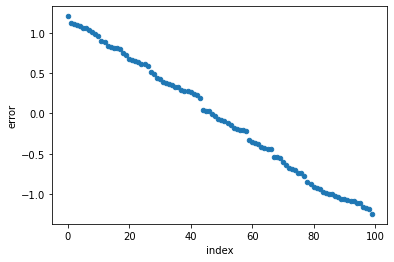

In [264]:
residual.plot(kind='scatter',y='error',x='index')

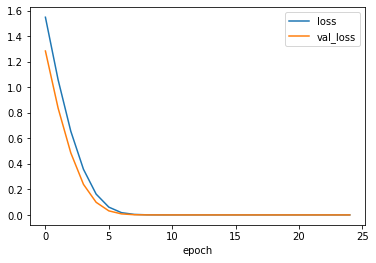

In [265]:
ploter_df=pd.DataFrame(history.history)
ploter_df['epoch']=pd.Series(ploter_df.index.values)
ploter_df.plot(kind='line',x='epoch',y=['loss','val_loss'])

In [267]:
model.weights

[<tf.Variable 'dense_35/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 0.04083156, -0.4761791 , -0.60317546,  0.05489169],
        [ 0.5042869 , -0.32067814,  0.2713424 ,  0.5627328 ],
        [ 0.8442392 , -0.37459305, -0.55768794, -0.4782824 ],
        [ 0.3163549 , -0.2988154 , -0.42488408,  0.46203387]],
       dtype=float32)>,
 <tf.Variable 'dense_35/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.00085962, -0.00223667, -0.00714221,  0.00219298], dtype=float32)>,
 <tf.Variable 'dense_36/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[ 0.34894264],
        [-0.26927578],
        [-0.20349063],
        [-0.42996818]], dtype=float32)>,
 <tf.Variable 'dense_36/bias:0' shape=(1,) dtype=float32, numpy=array([-0.00141272], dtype=float32)>]

In [308]:
def build_model():
    model=tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(4,input_shape=(4,)))
    model.add(tf.keras.layers.Dense(15))
    model.add(tf.keras.layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])                         
    return model

model=build_model()
model.summary()


X=np.arange(0,2000).reshape(-1,4)
y=np.arange(5,(X.shape[0]+1)*5,5)

temp=pd.DataFrame(data=X)
temp['target']=pd.Series(y.reshape(-1,))
from sklearn.preprocessing import StandardScaler
inputs_standardizer=StandardScaler()
inputs_standardizer.fit_transform(temp.drop('target',axis=1).values.tolist())

target_standardizer=StandardScaler()
target_standardizer.fit_transform(temp['target'].values.reshape(-1,1).tolist())

norm_temp=pd.DataFrame(data=inputs_standardizer.fit_transform(temp.drop('target',axis=1).values.tolist()))
norm_temp['target']=pd.Series(target_standardizer.fit_transform(temp['target'].values.reshape(-1,1).tolist()).reshape(-1,))

train_dataset = temp.sample(frac=0.8,random_state=0)
test_dataset = temp.drop(train_dataset.index)

train_stats = temp.describe()
train_stats = train_stats.transpose()

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_target=normed_train_data.pop('target')
normed_test_target=normed_test_data.pop('target')

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stoping_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,restore_best_weights=True)
history=model.fit(normed_train_data,normed_train_target,validation_split=0.2,epochs=250,verbose=1,callbacks=[tensorboard_callback,early_stoping_callback],batch_size=10)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_82 (Dense)             (None, 15)                75        
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 16        
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 0s 7ms/step - loss: 1.4980 - mae: 0.9969 - mse: 1.4980 - val_loss: 0.2148 - val_mae: 0.3964 - val_mse: 0.2148
Epoch 2/250
32/32 [==============================] - 0s 2ms/step - loss: 0.0386 - mae: 0.1224 - mse: 0.0386 - val_loss: 0.0023 - val_mae: 0.0411 - val_mse: 0.0023
Epoch 3/250
32/32 [==============================] - 0s 2ms

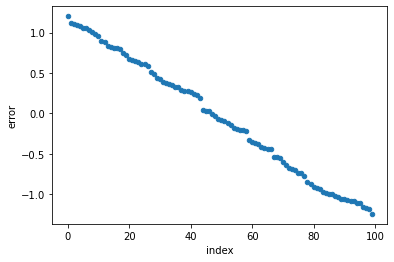

In [309]:
residual=pd.DataFrame([{'y_hat':i,'y_pred':j[0],'error':(j[0]-i)} for i,j in zip(test_dataset['target'],target_standardizer.inverse_transform(model.predict(normed_test_data)))])
residual['index']=pd.Series(residual.index.values)
residual.plot(kind='scatter',y='error',x='index')

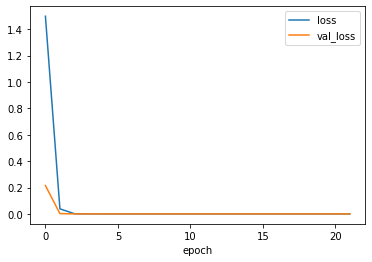

In [310]:
ploter_df=pd.DataFrame(history.history)
ploter_df['epoch']=pd.Series(ploter_df.index.values)
ploter_df.plot(kind='line',x='epoch',y=['loss','val_loss'])